<a href="https://colab.research.google.com/github/pszemraj/ml4hc-s22-project01/blob/add-ensemble-results/notebooks/colab/ensemble/Ensembles_PBT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Basic Ensembling of Model Outputs </center>

<font color="pink"> - this one is for the PTB dataset </font>


In [ ]:
#@markdown add auto-Colab formatting with `IPython.display`
from IPython.display import HTML, display
# colab formatting
def set_css():
    display(
        HTML(
            """
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  """
        )
    )

get_ipython().events.register("pre_run_cell", set_css)

In [ ]:
!pip install -U pandas -q
import pandas as pd

In [ ]:
!python -m pip uninstall -y matplotlib
!pip install matplotlib==3.1.3 -q
import matplotlib.pyplot as plt

Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.1.0 requires matplotlib>=3.2.0, but you have matplotlib 3.1.3 which is incompatible.
autoviz 0.1.36 requires matplotlib>=3.3.3, but you have matplotlib 3.1.3 which is incompatible.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install scikit-learn==0.23.2 -q
import sklearn

In [ ]:
#@title mount drive
from pathlib import Path
from google.colab import drive

drive_base_str = '/content/drive'
drive.mount(drive_base_str)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U pycaret[full] -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!nvidia-smi

Tue Mar 29 01:01:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    45W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# setup

In [ ]:
#@markdown add auto-Colab formatting with `IPython.display`
from IPython.display import HTML, display
# colab formatting
def set_css():
    display(
        HTML(
            """
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  """
        )
    )

get_ipython().events.register("pre_run_cell", set_css)

In [ ]:
#@markdown determine root
import os
from pathlib import Path
peter_base = Path('/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project1/')

if peter_base.exists() and peter_base.is_dir():
    path = str(peter_base.resolve())
else:
    # original
    path = '/content/drive/MyDrive/ETH/'

print(f"base drive dir is:\n{path}")

base drive dir is:
/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project1


## define folder for outputs

In [ ]:
_out_dir_name = "Trained-Results-Analysis" #@param {type:"string"}

output_path = os.path.join(path, _out_dir_name)
os.makedirs(output_path, exist_ok=True)
print(f"notebook outputs will be stored in:\n{output_path}")

notebook outputs will be stored in:
/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project1/Trained-Results-Analysis


## util functions

In [ ]:
import os
import time
import shutil
from google.colab import files
from os.path import join
# /content/SHAP summary.png
def grab_pycaret_export(filename:str, file_dir=None, new_name=None,
                        destination=None):
    """
    grab_pycaret_export - pycaret only saves the same filename to the local wd
                            which is a problem if you want multiple of the plot..
    """

    file_dir = os.getcwd() if file_dir is None else file_dir
    orig_path = join(file_dir, filename)

    if new_name is not None:
        new_path = join(file_dir, new_name)
        os.rename(orig_path, new_path)
    else:
        new_path = orig_path
        new_name = filename
    
    if destination is None:
        print(f"downloading {new_path}")
        time.sleep(2)
        files.download(new_path)
    else:
        shutil.move(new_path, join(destination, new_name))
        # shutil.copy(new_path, join(file_dir, new_name))
        print(f"moved file to {file_dir}")



In [ ]:
# grab_pycaret_export('SHAP summary.png', new_name="export-test.png", 
#                     destination='/content/drive/MyDrive/Analysis')

# test basic ensembling with PyCaret

- docs can be found [here](https://pycaret.gitbook.io/docs/get-started/tutorials)


In [ ]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [ ]:
import pandas as pd 

In [ ]:
root_dir = Path(path)
# /content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project1/Trained-Results-Analysis/PTB_ensemble/ptb_testset_model_predictions.csv
ptb_result_path = root_dir / "Trained-Results-Analysis" / "PTB_ensemble" / "ptb_testset_model_predictions.csv"
PTB_df = pd.read_csv(ptb_result_path)

In [ ]:
ptb_outpath = Path(output_path) / "PTB_ensemble"
ptb_figures = ptb_outpath / "ptb_figures"

ptb_outpath.mkdir(exist_ok=True)
ptb_figures.mkdir(exist_ok=True)

In [ ]:
from pycaret.classification import *

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
from pycaret.classification import setup

from pycaret.classification import setup
mitbih_exp = setup(data = PTB_df, target = 'actual_class', 
                   log_experiment = True, experiment_name = "PTB_ensemble1",
                session_id=69, 
                use_gpu=True)
                

Description            Value
0                               session_id               69
1                                   Target     actual_class
2                              Target Type           Binary
3                            Label Encoded             None
4                            Original Data        (2911, 6)
5                           Missing Values            False
6                         Numeric Features                0
7                     Categorical Features                5
8                         Ordinal Features            False
9                High Cardinality Features            False
10                 High Cardinality Method             None
11                   Transformed Train Set        (2037, 5)
12                    Transformed Test Set         (874, 5)
13                      Shuffle Train-Test             True
14                     Stratify Train-Test            False
15                          Fold Generator  StratifiedKFold
16                             Fold Number               10
17                                CPU Jobs               -1
18                                 Use GPU             True
19                          Log Experiment             True
20                         Experiment Name    PTB_ensemble1
21                                     USI             18b6
22                         Imputation Type           simple
23          Iterative Imputation Iteration             None
24                         Numeric Imputer             mean
25      Iterative Imputation Numeric Model             None
26                     Categorical Imputer         constant
27  Iterative Imputation Categorical Model             None
28           Unknown Categoricals Handling   least_frequent
29                               Normalize            False
30                        Normalize Method             None
31                          Transformation            False
32                   Transformation Method             None
33                                     PCA            False
34                              PCA Method             None
35                          PCA Components             None
36                     Ignore Low Variance            False
37                     Combine Rare Levels            False
38                    Rare Level Threshold             None
39                         Numeric Binning            False
40                         Remove Outliers            False
41                      Outliers Threshold             None
42                Remove Multicollinearity            False
43             Multicollinearity Threshold             None
44             Remove Perfect Collinearity             True
45                              Clustering            False
46                    Clustering Iteration             None
47                     Polynomial Features            False
48                       Polynomial Degree             None
49                    Trignometry Features            False
50                    Polynomial Threshold             None
51                          Group Features            False
52                       Feature Selection            False
53                Feature Selection Method          classic
54            Features Selection Threshold             None
55                     Feature Interaction            False
56                           Feature Ratio            False
57                   Interaction Threshold             None
58                           Fix Imbalance            False
59                    Fix Imbalance Method            SMOTE

2022/03/29 01:01:38 INFO mlflow.tracking.fluent: Experiment with name 'PTB_ensemble1' does not exist. Creating a new experiment.


In [ ]:
# add metric
from sklearn.metrics import balanced_accuracy_score
add_metric('balanced_accuracy', 'Balanced Accuracy', 
           balanced_accuracy_score, greater_is_better = True)

Name                                                 Balanced Accuracy
Display Name                                         Balanced Accuracy
Score Function       <function balanced_accuracy_score at 0x7f362a3...
Scorer                            make_scorer(balanced_accuracy_score)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: balanced_accuracy, dtype: object

In [ ]:
ptb_best = compare_models()
ptb_ensemble_overview = pull()


Model  Accuracy     AUC  Recall   Prec.  \
et                 Extra Trees Classifier    0.9907  0.9884  0.9959  0.9913   
knn                K Neighbors Classifier    0.9897  0.9941  0.9945  0.9912   
catboost              CatBoost Classifier    0.9897  0.9972  0.9959  0.9900   
lr                    Logistic Regression    0.9892  0.9970  0.9945  0.9906   
dt               Decision Tree Classifier    0.9892  0.9858  0.9945  0.9906   
ridge                    Ridge Classifier    0.9892  0.0000  0.9945  0.9906   
lda          Linear Discriminant Analysis    0.9892  0.9901  0.9945  0.9906   
xgboost         Extreme Gradient Boosting    0.9892  0.9972  0.9959  0.9893   
lightgbm  Light Gradient Boosting Machine    0.9892  0.9973  0.9952  0.9900   
rf               Random Forest Classifier    0.9887  0.9940  0.9959  0.9886   
gbc          Gradient Boosting Classifier    0.9887  0.9971  0.9959  0.9886   
ada                  Ada Boost Classifier    0.9867  0.9970  0.9898  0.9919   
svm                   SVM - Linear Kernel    0.9858  0.0000  0.9911  0.9892   
nb                            Naive Bayes    0.9833  0.9970  0.9809  0.9959   
qda       Quadratic Discriminant Analysis    0.9818  0.9966  0.9809  0.9939   
dummy                    Dummy Classifier    0.7207  0.5000  1.0000  0.7207   

              F1   Kappa     MCC  Balanced Accuracy  TT (Sec)  
et        0.9936  0.9766  0.9769             0.9865     1.003  
knn       0.9929  0.9742  0.9744             0.9858     0.228  
catboost  0.9929  0.9741  0.9744             0.9847     0.746  
lr        0.9925  0.9730  0.9731             0.9849     0.018  
dt        0.9925  0.9730  0.9732             0.9849     0.013  
ridge     0.9925  0.9730  0.9731             0.9849     0.010  
lda       0.9925  0.9730  0.9731             0.9849     0.012  
xgboost   0.9926  0.9729  0.9732             0.9839    14.242  
lightgbm  0.9925  0.9729  0.9732             0.9844     0.050  
rf        0.9922  0.9717  0.9720             0.9830     1.033  
gbc       0.9922  0.9717  0.9720             0.9830     0.108  
ada       0.9908  0.9670  0.9672             0.9843     0.119  
svm       0.9902  0.9645  0.9647             0.9815     0.013  
nb        0.9883  0.9591  0.9597             0.9852     0.013  
qda       0.9873  0.9554  0.9560             0.9825     0.012  
dummy     0.8377  0.0000  0.0000             0.5000     0.008

In [ ]:
header_overview_ptb = ptb_outpath / f"PTB_ensemble_fit_search"
ptb_ensemble_overview.to_csv(header_overview_ptb.with_suffix('.csv'))
ptb_ensemble_overview.to_excel(header_overview_ptb.with_suffix('.xlsx'))

### tune best

In [ ]:
print(ptb_best)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=69, verbose=0,
                     warm_start=False)


In [ ]:
tuned_best = tune_model(ptb_best)
bm_tuning_stats = pull()

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Fold                                                             
0       1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
1       0.9951  0.9998  0.9932  1.0000  0.9966  0.9879  0.9880   
2       0.9951  1.0000  0.9932  1.0000  0.9966  0.9879  0.9880   
3       0.9951  0.9998  1.0000  0.9932  0.9966  0.9878  0.9878   
4       0.9951  0.9909  1.0000  0.9932  0.9966  0.9878  0.9878   
5       0.9804  0.9906  0.9864  0.9864  0.9864  0.9513  0.9513   
6       0.9804  0.9983  0.9932  0.9799  0.9865  0.9508  0.9511   
7       0.9901  0.9995  0.9932  0.9932  0.9932  0.9756  0.9756   
8       0.9901  0.9996  0.9932  0.9932  0.9932  0.9756  0.9756   
9       0.9754  0.9895  0.9932  0.9733  0.9832  0.9373  0.9380   
Mean    0.9897  0.9968  0.9945  0.9912  0.9929  0.9742  0.9743   
Std     0.0078  0.0043  0.0041  0.0085  0.0053  0.0196  0.0195   

      Balanced Accuracy  
Fold                     
0                1.0000  
1                0.9966  
2                0.9966  
3                0.9912  
4                0.9912  
5                0.9757  
6                0.9703  
7                0.9878  
8                0.9878  
9                0.9609  
Mean             0.9858  
Std              0.0121

In [ ]:
try:
    est_type = type(tuned_best.base_estimator_).__name__
except Exception as e:
    print(f"trying just the name due to.. {e}")
    est_type = type(tuned_best).__name__

bm_tuning_stats.to_csv(ptb_outpath / f"best_ensemble_PBT_tuning_stats_{est_type}.csv")
est_type

'ExtraTreeClassifier'

In [ ]:
evaluate_model(tuned_best)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
est_type = type(tuned_best.base_estimator_).__name__
best_path = ptb_outpath/ f"tuned_best_ensemble_cls_PTB={est_type}"
save_model(tuned_best, model_name=best_path)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='actual_class',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric...
                  ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight='balanced', criterion='gini',
                                       max_depth=4, max_features='sqrt',
          

#### interpret best model with SHAP

In [ ]:
try:
    interpret_model(tuned_best, save = True)
    grab_pycaret_export('SHAP summary.png', 
                        new_name=f"Best_Ensemble_PTB_{est_type}_interpret.png", 
                        destination=ptb_figures.resolve())
except Exception as e:
    print(e)

moved file to /content


#### predict with best model

In [ ]:
predictions = predict_model(tuned_best)
best_model_stats = pull()
predictions.head()

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa  \
0  Extra Trees Classifier    0.9943  0.9977     1.0  0.9922  0.9961  0.9855   

      MCC  Balanced Accuracy  
0  0.9856             0.9896

BILSTM187_ptb-2_preds_1  BidirGRU_ptb_preds_1  CNN_PTB_preds_0  \
0                      1.0                   1.0              0.0   
1                      1.0                   1.0              0.0   
2                      1.0                   1.0              0.0   
3                      0.0                   1.0              1.0   
4                      1.0                   1.0              0.0   

   GRU_ptb_preds_0  RNN_PTB_preds_0  actual_class  Label   Score  
0              0.0              0.0             1      1  0.9753  
1              0.0              0.0             1      1  0.9753  
2              0.0              0.0             1      1  0.9753  
3              0.0              0.0             0      1  0.5905  
4              0.0              0.0             1      1  0.9753

In [ ]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874 entries, 0 to 873
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   BILSTM187_ptb-2_preds_1  874 non-null    float32
 1   BidirGRU_ptb_preds_1     874 non-null    float32
 2   CNN_PTB_preds_0          874 non-null    float32
 3   GRU_ptb_preds_0          874 non-null    float32
 4   RNN_PTB_preds_0          874 non-null    float32
 5   actual_class             874 non-null    int64  
 6   Label                    874 non-null    int64  
 7   Score                    874 non-null    float64
dtypes: float32(5), float64(1), int64(2)
memory usage: 37.7 KB


In [ ]:
pred_out = ptb_outpath  / f"best_ensemble_preds_PTBDB_{est_type}"
predictions.to_csv(pred_out.with_suffix('.csv'))

### logistic regression

In [ ]:
lr = create_model('lr')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Fold                                                             
0       0.9951  0.9999  1.0000  0.9932  0.9966  0.9878  0.9878   
1       0.9951  0.9999  0.9932  1.0000  0.9966  0.9879  0.9880   
2       0.9951  0.9999  0.9932  1.0000  0.9966  0.9879  0.9880   
3       0.9951  0.9999  1.0000  0.9932  0.9966  0.9878  0.9878   
4       0.9951  0.9913  1.0000  0.9932  0.9966  0.9878  0.9878   
5       0.9804  0.9909  0.9864  0.9864  0.9864  0.9513  0.9513   
6       0.9804  0.9986  0.9932  0.9799  0.9865  0.9508  0.9511   
7       0.9901  0.9998  0.9932  0.9932  0.9932  0.9756  0.9756   
8       0.9901  0.9997  0.9932  0.9932  0.9932  0.9756  0.9756   
9       0.9754  0.9901  0.9932  0.9733  0.9832  0.9373  0.9380   
Mean    0.9892  0.9970  0.9945  0.9906  0.9925  0.9730  0.9731   
Std     0.0072  0.0041  0.0041  0.0080  0.0050  0.0183  0.0182   

      Balanced Accuracy  
Fold                     
0                0.9912  
1                0.9966  
2                0.9966  
3                0.9912  
4                0.9912  
5                0.9757  
6                0.9703  
7                0.9878  
8                0.9878  
9                0.9609  
Mean             0.9849  
Std              0.0113

In [ ]:
tuned_lr = tune_model(lr)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Fold                                                             
0       0.9951  0.9999  1.0000  0.9932  0.9966  0.9878  0.9878   
1       0.9951  0.9999  0.9932  1.0000  0.9966  0.9879  0.9880   
2       0.9951  0.9999  0.9932  1.0000  0.9966  0.9879  0.9880   
3       0.9951  0.9999  1.0000  0.9932  0.9966  0.9878  0.9878   
4       0.9951  0.9913  1.0000  0.9932  0.9966  0.9878  0.9878   
5       0.9804  0.9906  0.9864  0.9864  0.9864  0.9513  0.9513   
6       0.9755  0.9986  0.9932  0.9733  0.9832  0.9381  0.9388   
7       0.9901  0.9998  0.9932  0.9932  0.9932  0.9756  0.9756   
8       0.9901  0.9997  0.9932  0.9932  0.9932  0.9756  0.9756   
9       0.9754  0.9901  0.9932  0.9733  0.9832  0.9373  0.9380   
Mean    0.9887  0.9970  0.9945  0.9899  0.9922  0.9717  0.9719   
Std     0.0079  0.0041  0.0041  0.0091  0.0054  0.0201  0.0199   

      Balanced Accuracy  
Fold                     
0                0.9912  
1                0.9966  
2                0.9966  
3                0.9912  
4                0.9912  
5                0.9757  
6                0.9615  
7                0.9878  
8                0.9878  
9                0.9609  
Mean             0.9841  
Std              0.0127

In [ ]:
plot_model(tuned_lr, plot = 'confusion_matrix', save=True,
           plot_kwargs = {'percent' : True})

grab_pycaret_export('Confusion Matrix.png', 
                        new_name="LR_Ensemble_PTB_confusionmat.png", 
                        destination=ptb_figures.resolve()
                        )

moved file to /content


In [ ]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
%%capture
save_model(tuned_lr, model_name=ptb_outpath/"tuned_lr_ptb")


### lightgbm

In [ ]:
lightgbm = create_model('lightgbm')


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Fold                                                             
0       0.9951  0.9996  1.0000  0.9932  0.9966  0.9878  0.9878   
1       0.9902  0.9999  0.9864  1.0000  0.9932  0.9759  0.9762   
2       0.9951  0.9999  0.9932  1.0000  0.9966  0.9879  0.9880   
3       0.9902  0.9998  1.0000  0.9866  0.9932  0.9754  0.9757   
4       0.9951  0.9921  1.0000  0.9932  0.9966  0.9878  0.9878   
5       0.9853  0.9913  0.9932  0.9865  0.9898  0.9633  0.9634   
6       0.9755  0.9990  0.9932  0.9733  0.9832  0.9381  0.9388   
7       0.9951  0.9998  1.0000  0.9932  0.9966  0.9877  0.9878   
8       0.9901  0.9997  0.9863  1.0000  0.9931  0.9759  0.9761   
9       0.9803  0.9913  1.0000  0.9735  0.9866  0.9496  0.9508   
Mean    0.9892  0.9973  0.9952  0.9900  0.9925  0.9729  0.9732   
Std     0.0065  0.0037  0.0053  0.0095  0.0044  0.0166  0.0163   

      Balanced Accuracy  
Fold                     
0                0.9912  
1                0.9932  
2                0.9966  
3                0.9825  
4                0.9912  
5                0.9791  
6                0.9615  
7                0.9912  
8                0.9932  
9                0.9643  
Mean             0.9844  
Std              0.0118

In [ ]:
tuned_lightgbm = tune_model(lightgbm)


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Fold                                                             
0       0.9951  0.9996  1.0000  0.9932  0.9966  0.9878  0.9878   
1       0.9951  0.9999  0.9932  1.0000  0.9966  0.9879  0.9880   
2       0.9951  0.9999  0.9932  1.0000  0.9966  0.9879  0.9880   
3       0.9951  0.9999  1.0000  0.9932  0.9966  0.9878  0.9878   
4       0.9951  0.9905  1.0000  0.9932  0.9966  0.9878  0.9878   
5       0.9804  0.9899  0.9864  0.9864  0.9864  0.9513  0.9513   
6       0.9804  0.9986  0.9932  0.9799  0.9865  0.9508  0.9511   
7       0.9901  0.9998  0.9932  0.9932  0.9932  0.9756  0.9756   
8       0.9901  0.9997  0.9932  0.9932  0.9932  0.9756  0.9756   
9       0.9754  0.9892  0.9932  0.9733  0.9832  0.9373  0.9380   
Mean    0.9892  0.9967  0.9945  0.9906  0.9925  0.9730  0.9731   
Std     0.0072  0.0045  0.0041  0.0080  0.0050  0.0183  0.0182   

      Balanced Accuracy  
Fold                     
0                0.9912  
1                0.9966  
2                0.9966  
3                0.9912  
4                0.9912  
5                0.9757  
6                0.9703  
7                0.9878  
8                0.9878  
9                0.9609  
Mean             0.9849  
Std              0.0113

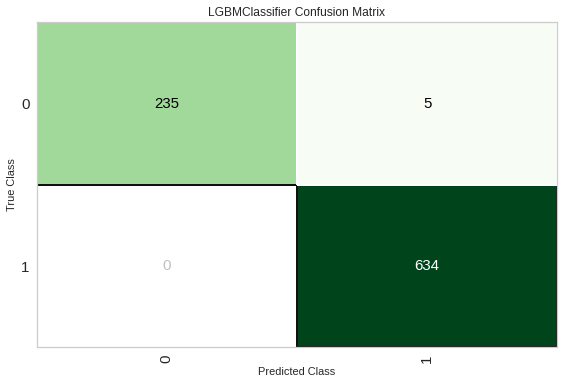

In [ ]:
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

In [ ]:
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
# interpret model
interpret_model(tuned_lightgbm, save = True)
grab_pycaret_export('SHAP summary.png', 
                        new_name="lightgbm_Ensemble_PTB_interpret.png", 
                        destination=ptb_figures.resolve()
                        )

moved file to /content


In [ ]:
%%capture

save_model(tuned_lightgbm, model_name=ptb_outpath/"ensemble_lgbm_ptb")

### xgboost

In [ ]:
xgboost = create_model('xgboost')


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Fold                                                             
0       0.9951  0.9996  1.0000  0.9932  0.9966  0.9878  0.9878   
1       0.9902  0.9998  0.9932  0.9932  0.9932  0.9757  0.9757   
2       0.9951  0.9999  0.9932  1.0000  0.9966  0.9879  0.9880   
3       0.9902  0.9995  1.0000  0.9866  0.9932  0.9754  0.9757   
4       0.9951  0.9921  1.0000  0.9932  0.9966  0.9878  0.9878   
5       0.9853  0.9913  0.9932  0.9865  0.9898  0.9633  0.9634   
6       0.9755  0.9990  0.9932  0.9733  0.9832  0.9381  0.9388   
7       0.9951  0.9997  1.0000  0.9932  0.9966  0.9877  0.9878   
8       0.9901  0.9998  0.9863  1.0000  0.9931  0.9759  0.9761   
9       0.9803  0.9908  1.0000  0.9735  0.9866  0.9496  0.9508   
Mean    0.9892  0.9972  0.9959  0.9893  0.9926  0.9729  0.9732   
Std     0.0065  0.0038  0.0045  0.0090  0.0044  0.0166  0.0163   

      Balanced Accuracy  
Fold                     
0                0.9912  
1                0.9878  
2                0.9966  
3                0.9825  
4                0.9912  
5                0.9791  
6                0.9615  
7                0.9912  
8                0.9932  
9                0.9643  
Mean             0.9839  
Std              0.0116

In [ ]:
tuned_xg = tune_model(xgboost)


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Fold                                                             
0       0.9951  0.9999     1.0  0.9932  0.9966  0.9878  0.9878   
1       0.9951  1.0000     1.0  0.9932  0.9966  0.9878  0.9878   
2       0.9951  1.0000     1.0  0.9932  0.9966  0.9878  0.9878   
3       0.9902  0.9998     1.0  0.9866  0.9932  0.9754  0.9757   
4       0.9951  0.9913     1.0  0.9932  0.9966  0.9878  0.9878   
5       0.9902  0.9893     1.0  0.9866  0.9932  0.9754  0.9757   
6       0.9755  0.9987     1.0  0.9671  0.9833  0.9375  0.9393   
7       0.9951  0.9998     1.0  0.9932  0.9966  0.9877  0.9878   
8       0.9951  0.9998     1.0  0.9932  0.9966  0.9877  0.9878   
9       0.9803  0.9901     1.0  0.9735  0.9866  0.9496  0.9508   
Mean    0.9907  0.9969     1.0  0.9873  0.9936  0.9764  0.9768   
Std     0.0068  0.0044     0.0  0.0090  0.0046  0.0174  0.0168   

      Balanced Accuracy  
Fold                     
0                0.9912  
1                0.9912  
2                0.9912  
3                0.9825  
4                0.9912  
5                0.9825  
6                0.9561  
7                0.9912  
8                0.9912  
9                0.9643  
Mean             0.9833  
Std              0.0122

In [ ]:
evaluate_model(tuned_xg)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
# interpret model
interpret_model(tuned_xg, save = True)
grab_pycaret_export('SHAP summary.png', 
                        new_name="xgboost_Ensemble_PTB_interpret.png", 
                        destination=ptb_figures.resolve()
                        )

moved file to /content


In [ ]:
%%capture
save_model(tuned_xg, model_name=ptb_outpath/"tuned_xg_ptb")


## save pycaret experiment

In [ ]:
get_logs()
pyc_ptb =  pull()


In [ ]:
exp_log_out = ptb_outpath / "ptb_ensemble_fitting_pycaret_LOGS"
pyc_ptb.to_csv(exp_log_out.with_suffix('.csv'))

# lazypredict

- docs are on [pypip here](https://pypi.org/project/lazypredict/)


In [ ]:
!pip install lazypredict -q


     |████████████████████████████████| 248 kB 5.1 MB/s 
     |████████████████████████████████| 72 kB 1.2 MB/s 
     |████████████████████████████████| 1.2 MB 83.3 MB/s 
     |████████████████████████████████| 10.1 MB 1.6 MB/s 
     |████████████████████████████████| 302 kB 86.2 MB/s 
     |████████████████████████████████| 14.5 MB 72.7 MB/s 
     |████████████████████████████████| 269 kB 88.5 MB/s 
     |████████████████████████████████| 127.6 MB 32 kB/s 
     |████████████████████████████████| 6.8 MB 10.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.1 which is incompatible.
pycaret 2.3.9 requires scikit-learn==0.23.2, but you have scikit-learn 0.23.1 which is incompatible.
pandas-profiling 3.1.0 

In [ ]:
lf_ptb_df = PTB_df.copy()
y = lf_ptb_df.actual_class.values
del lf_ptb_df["actual_class"]
X = lf_ptb_df.values
print(X.shape, y.shape)

(2911, 5) (2911,)


In [ ]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.5,random_state =123)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)


100%|██████████| 29/29 [00:01<00:00, 19.80it/s]


In [ ]:
import pprint as pp
# pp.pprint(models)

m_df = pd.DataFrame(models).convert_dtypes()
# m_df.to_csv()
# m_df.to_csv(ptb_outpath / "lazypredict_mitbih.csv")

m_df

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreeClassifier                1.00               0.99     0.99      1.00   
ExtraTreesClassifier               1.00               0.99     0.99      1.00   
LabelPropagation                   1.00               0.99     0.99      1.00   
LabelSpreading                     1.00               0.99     0.99      1.00   
BaggingClassifier                  1.00               0.99     0.99      1.00   
GaussianNB                         0.99               0.99     0.99      0.99   
DecisionTreeClassifier             0.99               0.99     0.99      0.99   
RandomForestClassifier             1.00               0.99     0.99      1.00   
PassiveAggressiveClassifier        0.99               0.99     0.99      0.99   
NearestCentroid                    0.99               0.99     0.99      0.99   
BernoulliNB                        0.99               0.99     0.99      0.99   
XGBClassifier                      0.99               0.99     0.99      0.99   
SGDClassifier                      0.99               0.99     0.99      0.99   
KNeighborsClassifier               0.99               0.99     0.99      0.99   
LGBMClassifier                     0.99               0.99     0.99      0.99   
AdaBoostClassifier                 0.99               0.99     0.99      0.99   
LogisticRegression                 0.99               0.99     0.99      0.99   
LinearSVC                          0.99               0.99     0.99      0.99   
NuSVC                              0.99               0.99     0.99      0.99   
LinearDiscriminantAnalysis         0.99               0.99     0.99      0.99   
RidgeClassifier                    0.99               0.99     0.99      0.99   
RidgeClassifierCV                  0.99               0.99     0.99      0.99   
CalibratedClassifierCV             0.99               0.99     0.99      0.99   
QuadraticDiscriminantAnalysis      0.99               0.99     0.99      0.99   
Perceptron                         0.99               0.99     0.99      0.99   
SVC                                0.99               0.99     0.99      0.99   
DummyClassifier                    0.61               0.51     0.51      0.61   

                               Time Taken  
Model                                      
ExtraTreeClassifier                  0.01  
ExtraTreesClassifier                 0.15  
LabelPropagation                     0.17  
LabelSpreading                       0.18  
BaggingClassifier                    0.03  
GaussianNB                           0.01  
DecisionTreeClassifier               0.01  
RandomForestClassifier               0.18  
PassiveAggressiveClassifier          0.01  
NearestCentroid                      0.02  
BernoulliNB                          0.01  
XGBClassifier                        0.07  
SGDClassifier                        0.01  
KNeighborsClassifier                 0.07  
LGBMClassifier                       0.05  
AdaBoostClassifier                   0.12  
LogisticRegression                   0.03  
LinearSVC                            0.04  
NuSVC                                0.08  
LinearDiscriminantAnalysis           0.02  
RidgeClassifier                      0.01  
RidgeClassifierCV                    0.01  
CalibratedClassifierCV               0.09  
QuadraticDiscriminantAnalysis        0.01  
Perceptron                           0.02  
SVC                                  0.02  
DummyClassifier                      0.01

In [ ]:
import joblib

_out_lp_ptb = Path(ptb_outpath) / "LP_ptb_ensemble_baselines_pandas.pkl"
joblib.dump(m_df, filename=_out_lp_ptb, compress=True)

['/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project1/Trained-Results-Analysis/PTB_ensemble/LP_ptb_ensemble_baselines_pandas.pkl']